In [33]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from tsaug import Drift, AddNoise, TimeWarp
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm
from pytz import timezone
import json
import os
import torch
from imputation_utils import masked_prediction, normalize_daily_variables

In [4]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60
IMAGE_HEIGHT = 370 # height size of standard spectrogram (matplotlib)
NFFT = 255 # 1 window in spectrogram is derived from NFFT datapoints
NOVERLAP = 128 # window hop in spectrogram

In [13]:
# User change:
TRANSFORMER_IMPUTATION = True # whether to use transformer imputation or linear interpolation

NORMALIZE_SUBJECTS = True # whether to normalize all variables subject-wise (to counteract high subject variability)

SEGMENT_LENGTH = 497 # width of one segment [pixels] (full day data is 370x497 pixels)
OVERLAP = 0.75 # of neighbouring segments [%]
FILTER_THRESHOLD = 0.5 # discard segment if contains >FILTER_THRESHOLD aritificial data [%]
AUGMENTATION_SIZE = 0.5 # size of additional augmented datapoints relative to full dataset [%]
AUGMENTATION_PROB = 0.25 # probability of single augmentation

TIME_WARP_MIN, TIME_WARP_MAX = 1.01, 3.0 # maximal ratio of max/min speed in the warped time line
NOISE_MIN, NOISE_MAX = 0.01, 0.02 # add random noise up to MIN-MAX
MAGNITUDE_WARP_MIN, MAGNITUDE_WARP_MAX = 0.01, 0.05 # random drift the signal up to MIN-MA
SCALING_STD = 0.05 # scale time-series by N(1, SCALING_STD)

In [6]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def plotter_spec(day, dat, NFFT=256, noverlap=128):
    """
    Plots spectrograms of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.specgram(time_series, Fs=SAMPLING_RATE, NFFT=NFFT, noverlap=NOVERLAP)

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def spectrogram_as_array(time_series, iteration=1):
    """
    Retrieves numerical data from spectrogram
    """
    # for stability
    time_series += np.random.normal(0.0, 1e-15)

    # calculate spectrogram
    fig = plt.figure()
    fig.add_subplot(111)
    plt.specgram(time_series,
                 Fs=SAMPLING_RATE,
                 NFFT=NFFT,
                 noverlap=NOVERLAP)
    plt.axis('off') # removes everything except content of plot

    # need to draw plot to create spectrogram
    fig.canvas.draw()

    # save pixels in numpy array
    numerical = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    numerical = numerical.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close() # prevent showing plot

    # remove white padding around spectrogram image
    height, width, channels = numerical.shape
    all_white_rows = np.where(np.sum(numerical[:, :, 0], axis=1) == 255 * width)[0]
    all_white_cols = np.where(np.sum(numerical[:, :, 0], axis=0) == 255 * height)[0]

    start_row, end_row = max(all_white_rows[all_white_rows - np.mean(all_white_rows) < 0]), \
                         min(all_white_rows[all_white_rows - np.mean(all_white_rows) > 0])
    start_col, end_col = max(all_white_cols[all_white_cols - np.mean(all_white_cols) < 0]), \
                         min(all_white_cols[all_white_cols - np.mean(all_white_cols) > 0])

    numerical = numerical[start_row:end_row, start_col:end_col, :]
    return numerical

def save_spectrogram(spectrogram, name):
    """
    Saves spectrogram as png
    """
    plt.figure()
    plt.imshow(spectrogram)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./Output/{name}.png')
    plt.close() # prevent showing plot

def segmentor(image):
    """
    Segments images into subimages (along width axis)
    """
    height, width, channels = image.shape
    segments = []
    delta = int((1 - OVERLAP) * SEGMENT_LENGTH) # distance between two windows

    start, end = 0, SEGMENT_LENGTH
    while True:
        # check if building one more segment is possible
        if end > width - 1: # last pixel column is image[:, width - 1, :]
            break
        else:
            # possible to build segment
            segment = image[:, start:end, :]
            segments.append(segment)

        # move window further
        start += delta
        end += delta

    return segments

def plot_segments(image):
    """
    Plots image with visible segmentations
    """
    segments = segmentor(image)

    plt.figure()
    n = len(segments)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(segments[i])
        plt.xticks([]), plt.yticks([])

def tz_diff(date, tz1, tz2):
    """
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    """
    tz1 = 'CET' if tz1 == 'CEST' else tz1 # CEST is just summertime CET
    tz2 = 'CET' if tz2 == 'CEST' else tz2 # CEST is just summertime CET

    date = pd.to_datetime(date)
    tz1, tz2 = timezone(tz1), timezone(tz2)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds / 3600

# Import data

In [7]:
# file path to data folder
path = './Output'

In [8]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Discarding data 1/2

Filter out variables from dataset

Text(0, 0.5, 'available data [%]')

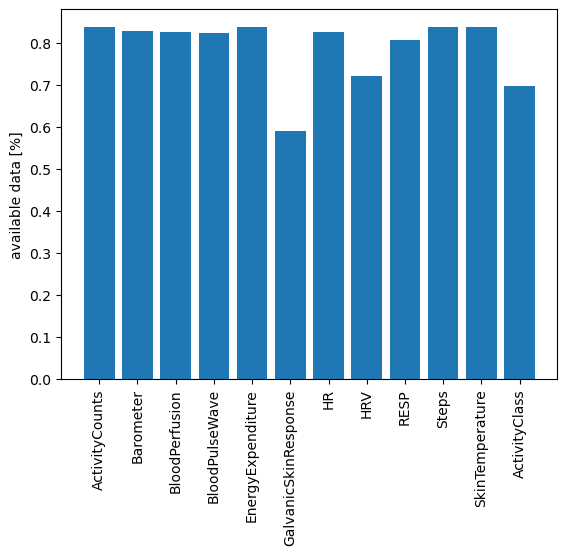

In [10]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

In [11]:
# discard variables from dataset (too much missing data)
to_discard = ['GalvanicSkinResponse', 'ActivityClass']

data = data.drop(columns=to_discard)
VARIABLES = [variable for variable in VARIABLES if variable not in to_discard]

Filter out days with sensors out all days

In [12]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) == 0: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days}')

Discarded days (sensor out): [114]


# Normalization

In [14]:
if not TRANSFORMER_IMPUTATION: # we normalize after imputation when using transformer
    if NORMALIZE_SUBJECTS:
        # normalize each variable considering only subject data
        days, _ = data.shape
        for subject in np.unique(data['subjectID']):
            days_subj = np.arange(days)[data['subjectID'] == subject]

            for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.
                # get mean, variance of all subject data
                full_time_series = np.array([datapoint for day in days_subj for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(full_time_series)

                # normalize accordingly
                for day in days_subj:
                    time_series = get_time_series(data, variable, day).reshape(-1, 1)
                    data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)

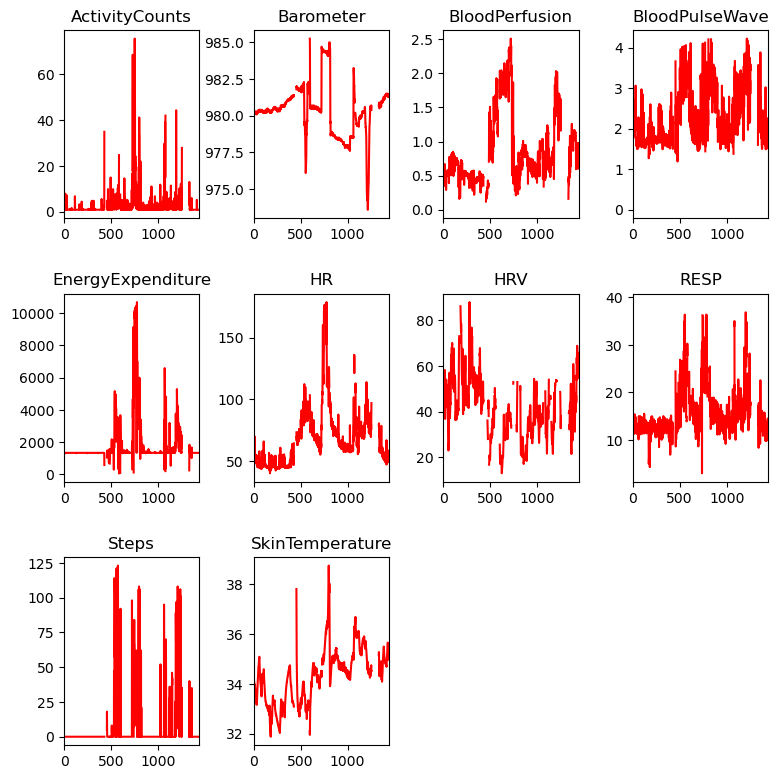

In [15]:
# visualize
plotter(np.random.choice(data.shape[0], 1, replace=False)[0], data)

# Imputation

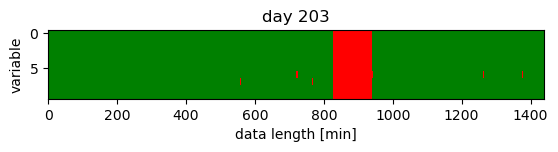

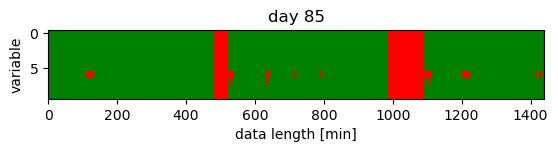

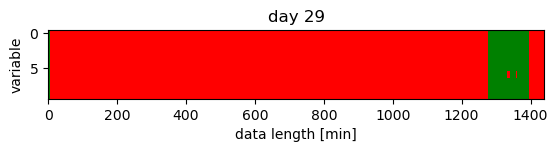

In [22]:
# visualize missing data (red: missing data, green: data)
N = 3
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

In [54]:
# imputation (everything)
if TRANSFORMER_IMPUTATION:
    # load transformer
    model = torch.load('./Models/transformer_imputation_final')

    # put onto gpu/cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    # dataframe with imputation data
    data_imputed = data.copy()

    # 1) Synchronize time-scale with timestamps
    n_days, _ = data.shape
    for day in tqdm(range(n_days)):
        # create dataframe with data by day (i.e. each row is full daily data of one variable, each column is a one-minute measurement)

        # timestamps
        date = data["date"].iloc[day] # date (year, month, day) of current day
        timestamps_full = pd.to_datetime(
            [f'{str(hour)}:{str(minute)}, {date}' for hour in range(0, 24)
             for minute in range(0, 60)]) # timestamps for one full day
        timestamps_available = pd.to_datetime(
            [f'{ts}, {date}' for ts in data['Timestamps'].iloc[day].split(',')]) # timestamps with data

        # assign data to correct timestamp
        rows = [{timestamp: np.NaN for timestamp in timestamps_full} for variable in VARIABLES] # initialize full day with NaNs
        rows_available = [get_time_series(data, variable, day) for variable in VARIABLES] # available data for day
        for variable, _ in enumerate(VARIABLES):
            for i, timestamp in enumerate(timestamps_available):
                rows[variable][timestamp] = rows_available[variable][i] # fill timestamps where we have data

        # build dataframe
        row_names = VARIABLES
        column_names = timestamps_full
        data_day = pd.DataFrame(data=rows,
                                index=row_names,
                                columns=column_names)

        # 2) Normalize variable-wise (for transformer)
        normalize_daily_variables(data_day)

        # 3) Impute using transformer
        data_day_imputed = masked_prediction(model, data_day, device)

        # insert into dataframe
        for i, variable in enumerate(VARIABLES):
            real_data = data_day.iloc[i, :] # data with NaNs
            imputed_data = data_day_imputed[i, :] # note that imputed data contains ALL datapoints (also non-NaNs), but might differ from real data
            real_data[np.isnan(real_data)] = imputed_data[np.isnan(real_data)] # pick imputed values where real data was NaN
            data_imputed[variable].iloc[day] = real_data

    # 4) Normalize (subject-wise)
    if NORMALIZE_SUBJECTS:
        # normalize each variable considering only subject data
        days, _ = data_imputed.shape
        for subject in np.unique(data_imputed['subjectID']):
            days_subj = np.arange(days)[data_imputed['subjectID'] == subject]

            for variable in [var for var in VARIABLES if var != 'ActivityClass']: # don't normalize categorical var.
                # get mean, variance of all subject data
                full_time_series = np.array([datapoint for day in days_subj for datapoint in get_time_series(data_imputed, variable, day)]).reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(full_time_series)

                # normalize accordingly
                for day in days_subj:
                    time_series = get_time_series(data_imputed, variable, day).reshape(-1, 1)
                    data_imputed[variable].iloc[day] = scaler.transform(time_series).reshape(-1)

else:
    MAX_FILL = 1440 # maximum imputation window (from both sides!)
    METHOD = 'linear' # imputation method

    data_imputed = imputer(data, max_fill=MAX_FILL, method=METHOD)

cuda


  0%|          | 0/409 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_36712\2685733012.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imputed[variable].iloc[day] = real_data
  0%|          | 1/409 [00:00<02:05,  3.25it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_36712\2685733012.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imputed[variable].iloc[day] = real_data
  0%|          | 2/409 [00:00<03:31,  1.92it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_36712\2685733012.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

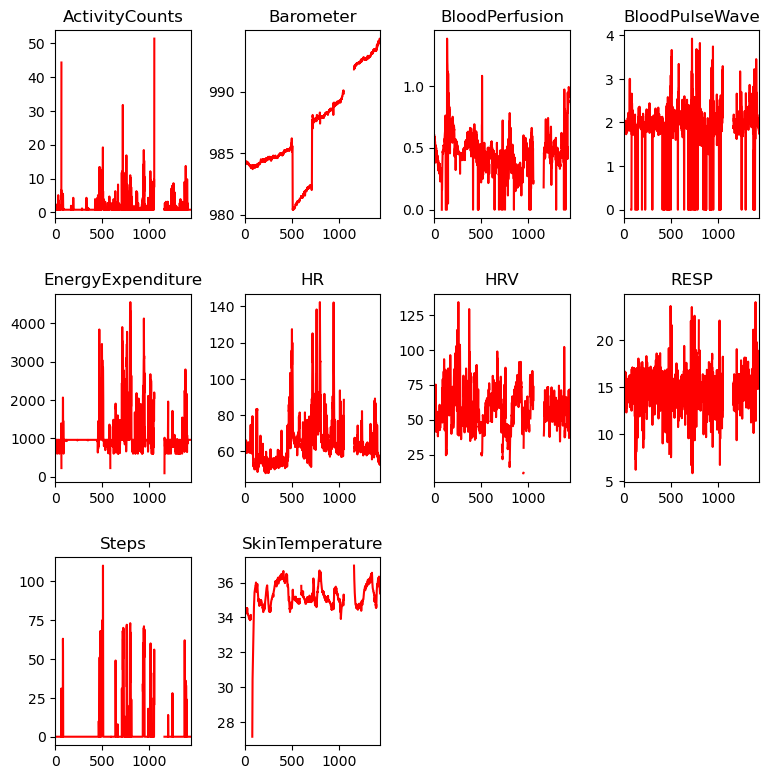

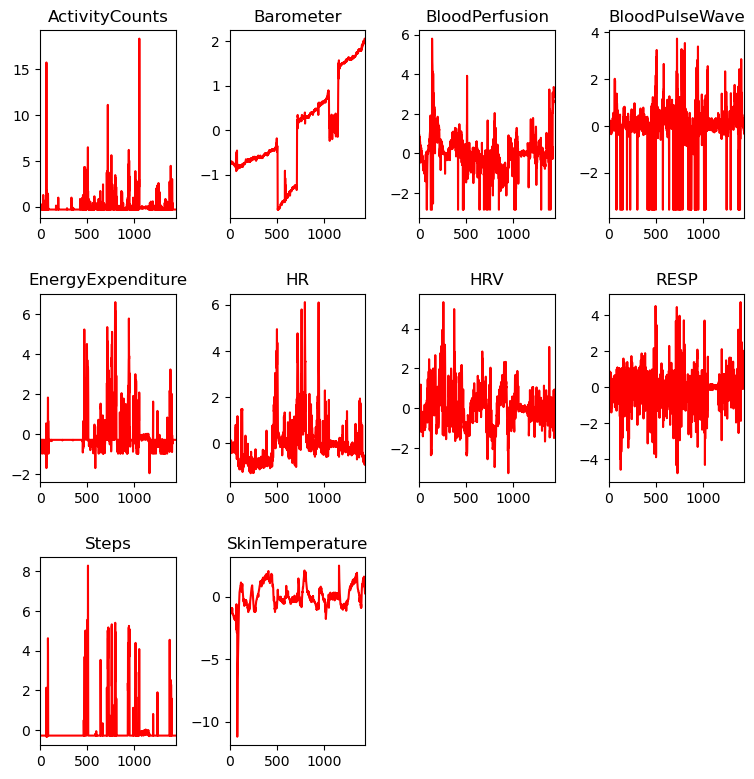

In [57]:
# visualize effect of imputation (red: fatigued, green: vigilant)
day = np.random.choice(data_imputed.shape[0], 1, replace=False)[0]
plotter(day, data)
plotter(day, data_imputed)

# Data augmentation

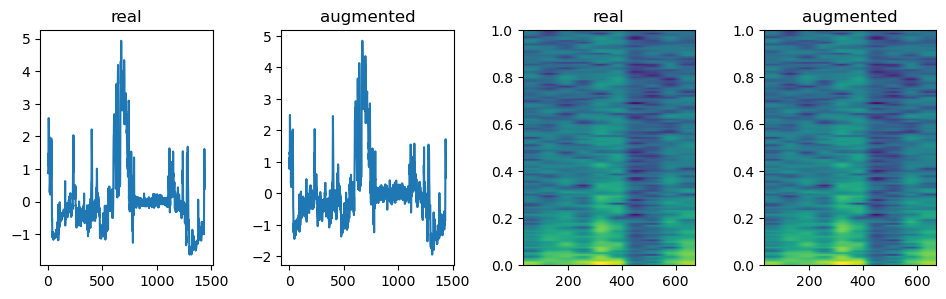

In [59]:
# select days to augment
days, _ = data_imputed.shape
augmented_days = np.random.choice(np.arange(days), int(days * AUGMENTATION_SIZE), replace=False)

# augmentation
augmentor = (
        TimeWarp(max_speed_ratio=(TIME_WARP_MIN, TIME_WARP_MAX)) * 1 @ AUGMENTATION_PROB # time warp
        + AddNoise(scale=(NOISE_MIN, NOISE_MAX)) @ AUGMENTATION_PROB  # noise
        + Drift(max_drift=(MAGNITUDE_WARP_MIN, MAGNITUDE_WARP_MAX)) @ AUGMENTATION_PROB # magnitude warp
)

data_augmented = {day: {variable: None for variable in VARIABLES} for day in augmented_days}
for day in augmented_days:
    for variable in VARIABLES:
        # augment variable
        time_series = get_time_series(data_imputed, variable, day)
        time_series_augmented = augmentor.augment(time_series)

        # scale
        if np.random.uniform(0, 1) < AUGMENTATION_PROB:
            time_series_augmented * np.random.normal(1, SCALING_STD, 1)

        # insert into augmented dataset
        data_augmented[day][variable] = time_series_augmented

data_augmented = pd.DataFrame.from_dict(data_augmented).transpose()

# visalization
day, variable = np.random.choice(augmented_days, 1)[0], np.random.choice(VARIABLES, 1)[0]
test_data = get_time_series(data_imputed, variable, day)

plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.5,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(1, 4, 1)
plt.plot(test_data)
plt.title('real')
plt.subplot(1, 4, 2)
plt.plot(augmentor.augment(test_data))
plt.title('augmented')

plt.subplot(1, 4, 3)
plt.specgram(test_data)
plt.title('real')
plt.subplot(1, 4, 4)
plt.specgram(augmentor.augment(test_data))
plt.title('augmented')
plt.show()

# Spectrogram conversion

In [60]:
# compute spectrogram for all days + variables
days, _ = data_imputed.shape
days_augmented = list(data_augmented.index)

data_spectrogram = {day: {variable: spectrogram_as_array(get_time_series(data_imputed, variable, day))
                          for variable in VARIABLES}
                    for day in range(days)}
data_spectrogram_augmented = {day: {variable: spectrogram_as_array(get_time_series(data_augmented, variable, day))
                                    for variable in VARIABLES}
                              for day in days_augmented}

In [61]:
# check if all spectrograms correct sizes
for variable in VARIABLES:
    # real data
    for day in data_spectrogram.keys():
        assert data_spectrogram[day][variable].shape[0] == IMAGE_HEIGHT, f'different height: {day}, {variable}'
    # augmented data
    for day in data_spectrogram_augmented.keys():
        assert data_spectrogram_augmented[day][variable].shape[0] == IMAGE_HEIGHT, f'different height: {day}, {variable}'
print('All spectrograms correct size!')

All spectrograms correct size!


Day: 117


C:\Users\jjung\anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


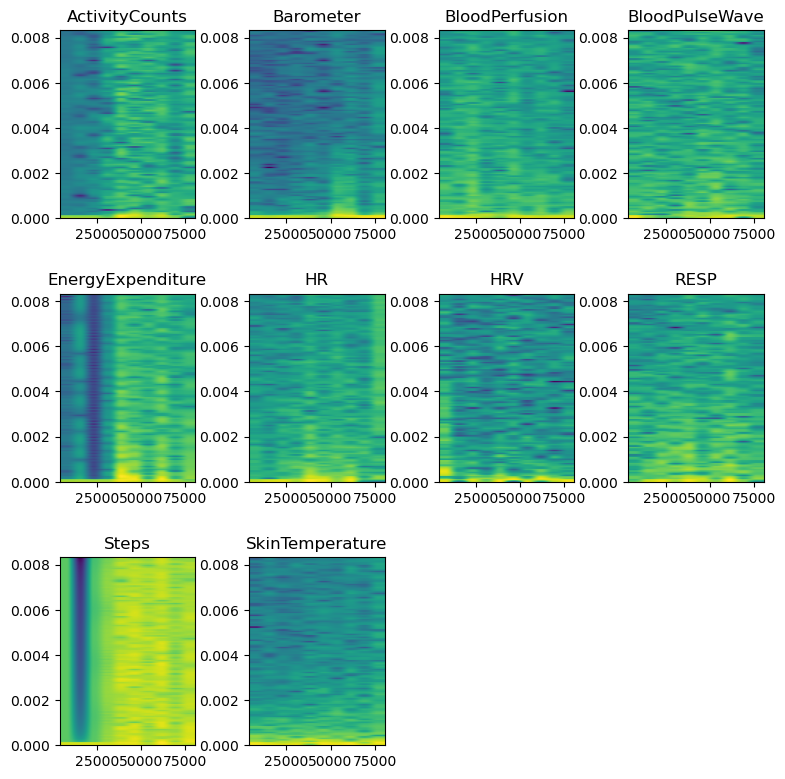

In [62]:
day = np.random.choice(np.arange(days), 1)[0]
print(f'Day: {day}')
plotter_spec(day, data_imputed)

# Build feature vector

TZdiff not needed as additional feature?

In [63]:
query = '''
SELECT subjectID, GROUP_CONCAT(DISTINCT timezone)
FROM data
GROUP BY subjectID
HAVING COUNT(DISTINCT timezone) > 1;'''
sqldf(query)

,subjectID,GROUP_CONCAT(DISTINCT timezone)
0,24,"CET,CEST"
1,26,"CET,CEST"
2,27,"CEST,CET"


combine augmented data with real

In [64]:
# create look-up table with additional data (date, subjectID, augmented) (for train/test split later)
metadata = []

# feature vector, labels
X, y = [], []

# real data
days = range(data.shape[0])
for day in days:
    x = []
    for variable in VARIABLES:
        x.append(data_spectrogram[day][variable])

    x = np.dstack(x) # stack spectrogram segments of variables
    X.append(x) # feature vector
    y.append([data['phF'].iloc[day], data['MF'].iloc[day]]) # labels
    metadata.append({'date': data['date'].iloc[day], 'subjectID': data['subjectID'].iloc[day], 'augmented': False}) # metadata


# augmented data
days_augmented = list(data_augmented.index) # index in data_augmented corresponds to day actual index in data
for day in days_augmented:
    x = []
    for variable in VARIABLES:
        x.append(data_spectrogram[day][variable])

    x = np.dstack(x) # stack spectrogram segments of variables
    X.append(x) # feature vector
    y.append([data['phF'].iloc[day], data['MF'].iloc[day]]) # labels
    metadata.append({'date': data['date'].iloc[day], 'subjectID': data['subjectID'].iloc[day], 'augmented': True}) # metadata

X, y = np.array(X), np.array(y)

In [65]:
print(f'Dataset: X: {X.shape}, y: {y.shape}')

Dataset: X: (613, 370, 497, 30), y: (613, 2)


"normalization"

In [66]:
X = X.astype('float32') / 255 # (WARNING: takes a lot of memory)

# Export data

In [67]:
# file path to data folder
output_path = './Output' if not TRANSFORMER_IMPUTATION else './Output/transformer_imputation'

Delete previous

In [69]:
# delete feature vecs
for file_name in os.listdir(output_path):
    if file_name[:14] == 'feature_vector' and file_name[:19] != 'feature_vector_stat':
        os.remove(f'{output_path}//{file_name}')

# delete labels
for file_name in os.listdir(output_path):
    if file_name[:6] == 'labels' and file_name[:11] != 'labels_stat':
        os.remove(f'{output_path}//{file_name}')

# delete metadata
try:
    os.remove(output_path + '/metadata.txt')
except Exception:
    'no metadata found'

print('cleared')

cleared


Save current

In [70]:
# save all vectors as separate files for data generator (WARNING: takes a lot of time)
with tqdm(total=len(X)) as pbar:
    for i, (x, y_) in enumerate(zip(X, y)):
        np.save(output_path + f'/feature_vector{i}', x)
        np.save(output_path + f'/labels{i}', y_)
        pbar.update(1)

100%|██████████| 613/613 [01:22<00:00,  7.40it/s]


In [71]:
# save metadata
with open(output_path + '/metadata.txt','w') as dat:
    dat.write(str(metadata))